In [ ]:
!pip install pyunpack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 5.9 MB/s 


In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyunpack import Archive
Archive('/content/drive/MyDrive/12_15_2022.zip').extractall('/content/images_not_formatted')

In [ ]:
import splitfolders
splitfolders.ratio('/content/images_not_formatted/12_15_2022', output="/content/output", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 582 files [00:00, 3552.76 files/s]


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf





In [ ]:
# Create a list with the filepaths for training and testing
train_dir = Path('/content/output/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('/content/output/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('/content/output/val')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [ ]:
train_filepaths

[PosixPath('/content/output/train/wisteria/a8f635bcba57af1aa76dab53fb48e247--wisteria-tree-purple-flowers.jpg'),
 PosixPath('/content/output/train/wisteria/15fe8fc5702e3ad65ff40eac2a113e08--wisteria-plant-flowering-vines.jpg'),
 PosixPath('/content/output/train/wisteria/honey-bee-worker-drinking-sucking-up-nectar-with-proboscis-on-wisteria-ERCGF1.jpg'),
 PosixPath('/content/output/train/wisteria/ebd1a4ccef8a61ebb9a1e9a9cc08c479--ink-art-wisteria.jpg'),
 PosixPath('/content/output/train/wisteria/a52141ff9c2a7108b71c43cba30412fa--wisteria-tree-wisteria-trellis.jpg'),
 PosixPath('/content/output/train/wisteria/native-alternative-invasive-imported-wisteria-3.jpg'),
 PosixPath('/content/output/train/wisteria/wisteria (1).jpg'),
 PosixPath('/content/output/train/wisteria/wisteria-plant-poisonous_800x.jpg'),
 PosixPath('/content/output/train/wisteria/7489247722f20f050c032546429d12f1--wisteria-bonsai-bonsai-trees.jpg'),
 PosixPath('/content/output/train/wisteria/50709f48b324e9e750028842e35f8d2

In [ ]:
def proc_img(filepath):
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [ ]:
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [ ]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 429

Number of different labels: 9

Labels: ['oleander' 'wisteria' 'lilies' 'castor_oil_plant' 'rhubarb' 'foxglove'
 'lily_of_the_valley' 'dieffenbachia' 'pothos']


In [ ]:
train_df.sample(5)

,Filepath,Label
75,/content/output/train/lilies/lilies (4).jpg,lilies
315,/content/output/train/rhubarb/Rhubarb-in-June.jpg,rhubarb
123,/content/output/train/rhubarb/rhubarb-gone-to-...,rhubarb
107,/content/output/train/wisteria/46artificial-fl...,wisteria
385,/content/output/train/dieffenbachia/dieffenbac...,dieffenbachia


In [ ]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset


In [ ]:
df_unique.sample(9)

,index,Filepath,Label
8,23,/content/output/train/pothos/istockphoto-12075...,pothos
3,4,/content/output/train/castor_oil_plant/ricinus...,castor_oil_plant
2,3,/content/output/train/lilies/easter-lilies-tox...,lilies
6,13,/content/output/train/lily_of_the_valley/varie...,lily_of_the_valley
1,1,/content/output/train/wisteria/296c5e8cbda37e7...,wisteria
0,0,/content/output/train/oleander/oleander-2-r.jpg,oleander
5,7,/content/output/train/foxglove/foxglove-plant-...,foxglove
4,6,/content/output/train/rhubarb/rhubarb-varietie...,rhubarb
7,21,/content/output/train/dieffenbachia/Dieffenbac...,dieffenbachia


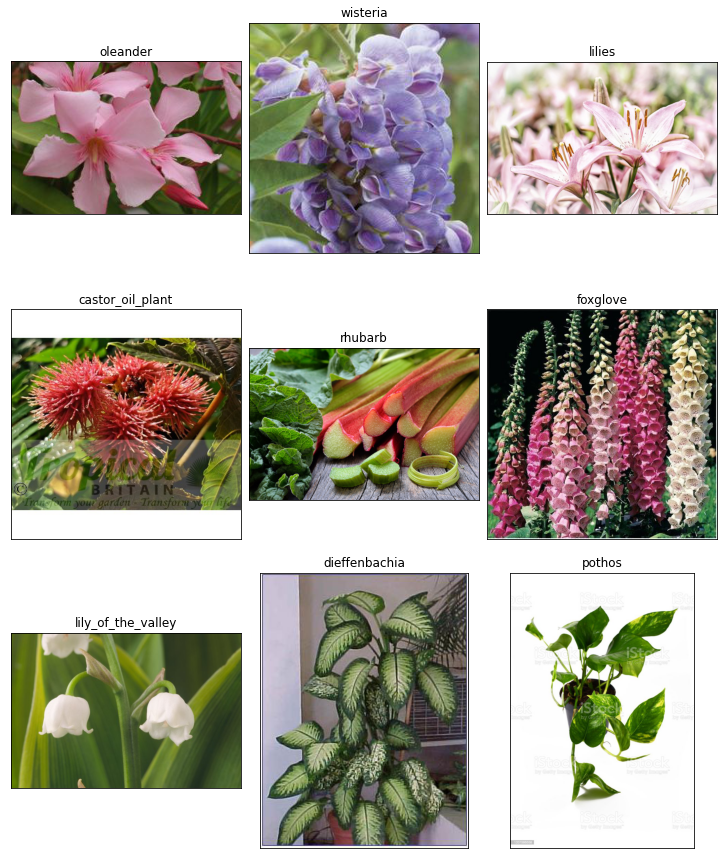

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 429 validated image filenames belonging to 9 classes.
Found 62 validated image filenames belonging to 9 classes.
Found 62 validated image filenames belonging to 9 classes.


In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 16,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
14/14 [==============================] - 12s 666ms/step - loss: 1.7342 - accuracy: 0.4499 - val_loss: 0.9417 - val_accuracy: 0.8226
Epoch 2/50
14/14 [==============================] - 7s 527ms/step - loss: 0.5422 - accuracy: 0.8741 - val_loss: 0.3786 - val_accuracy: 0.9032
Epoch 3/50
14/14 [==============================] - 7s 526ms/step - loss: 0.2317 - accuracy: 0.9231 - val_loss: 0.1531 - val_accuracy: 0.9839
Epoch 4/50
14/14 [==============================] - 7s 537ms/step - loss: 0.0770 - accuracy: 0.9953 - val_loss: 0.1193 - val_accuracy: 0.9839
Epoch 5/50
14/14 [==============================] - 7s 537ms/step - loss: 0.0375 - accuracy: 1.0000 - val_loss: 0.0849 - val_accuracy: 0.9839
Epoch 6/50
14/14 [==============================] - 7s 528ms/step - loss: 0.0241 - accuracy: 1.0000 - val_loss: 0.0986 - val_accuracy: 0.9839
Epoch 7/50
14/14 [==============================] - 7s 537ms/step - loss: 0.0160 - accuracy: 1.0000 - val_loss: 0.0769 - val_accuracy: 0.9677
Epoch

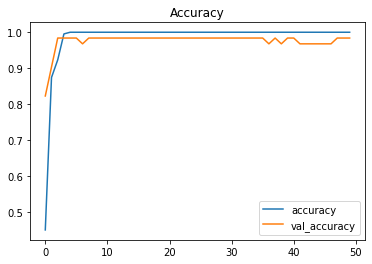

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

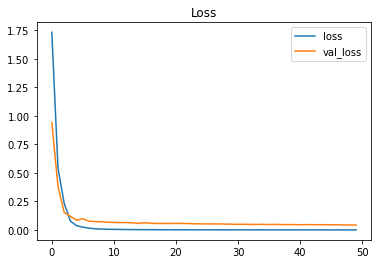

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

2/2 [==============================] - 2s 362ms/step


In [ ]:
pred

['oleander',
 'pothos',
 'lily_of_the_valley',
 'foxglove',
 'foxglove',
 'castor_oil_plant',
 'pothos',
 'rhubarb',
 'lilies',
 'castor_oil_plant',
 'oleander',
 'oleander',
 'rhubarb',
 'lily_of_the_valley',
 'dieffenbachia',
 'foxglove',
 'lilies',
 'pothos',
 'rhubarb',
 'dieffenbachia',
 'dieffenbachia',
 'wisteria',
 'lily_of_the_valley',
 'dieffenbachia',
 'lily_of_the_valley',
 'pothos',
 'castor_oil_plant',
 'oleander',
 'lilies',
 'dieffenbachia',
 'pothos',
 'pothos',
 'castor_oil_plant',
 'wisteria',
 'lilies',
 'wisteria',
 'oleander',
 'oleander',
 'wisteria',
 'castor_oil_plant',
 'pothos',
 'lilies',
 'dieffenbachia',
 'lily_of_the_valley',
 'foxglove',
 'oleander',
 'lilies',
 'rhubarb',
 'lily_of_the_valley',
 'castor_oil_plant',
 'castor_oil_plant',
 'lily_of_the_valley',
 'wisteria',
 'lilies',
 'lilies',
 'rhubarb',
 'castor_oil_plant',
 'wisteria',
 'foxglove',
 'rhubarb',
 'dieffenbachia',
 'foxglove']

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 98.39%


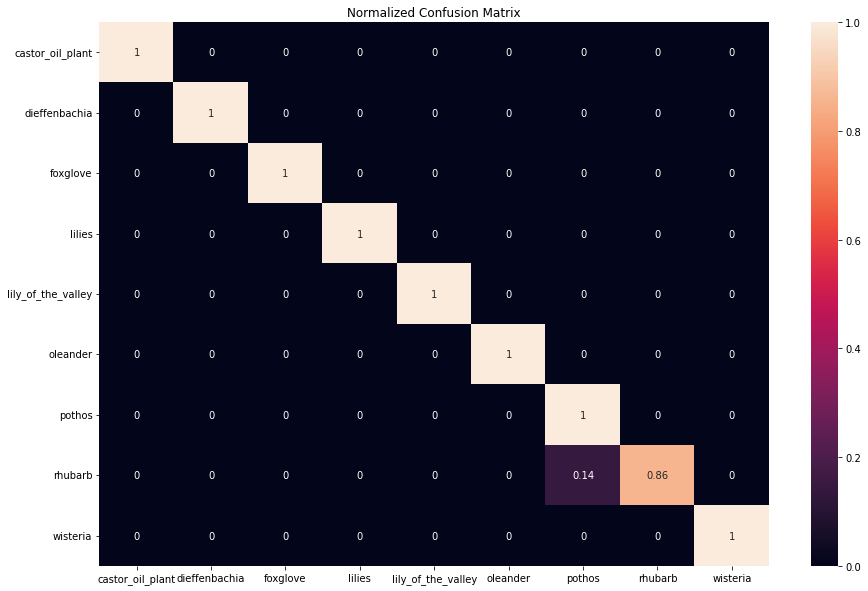

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

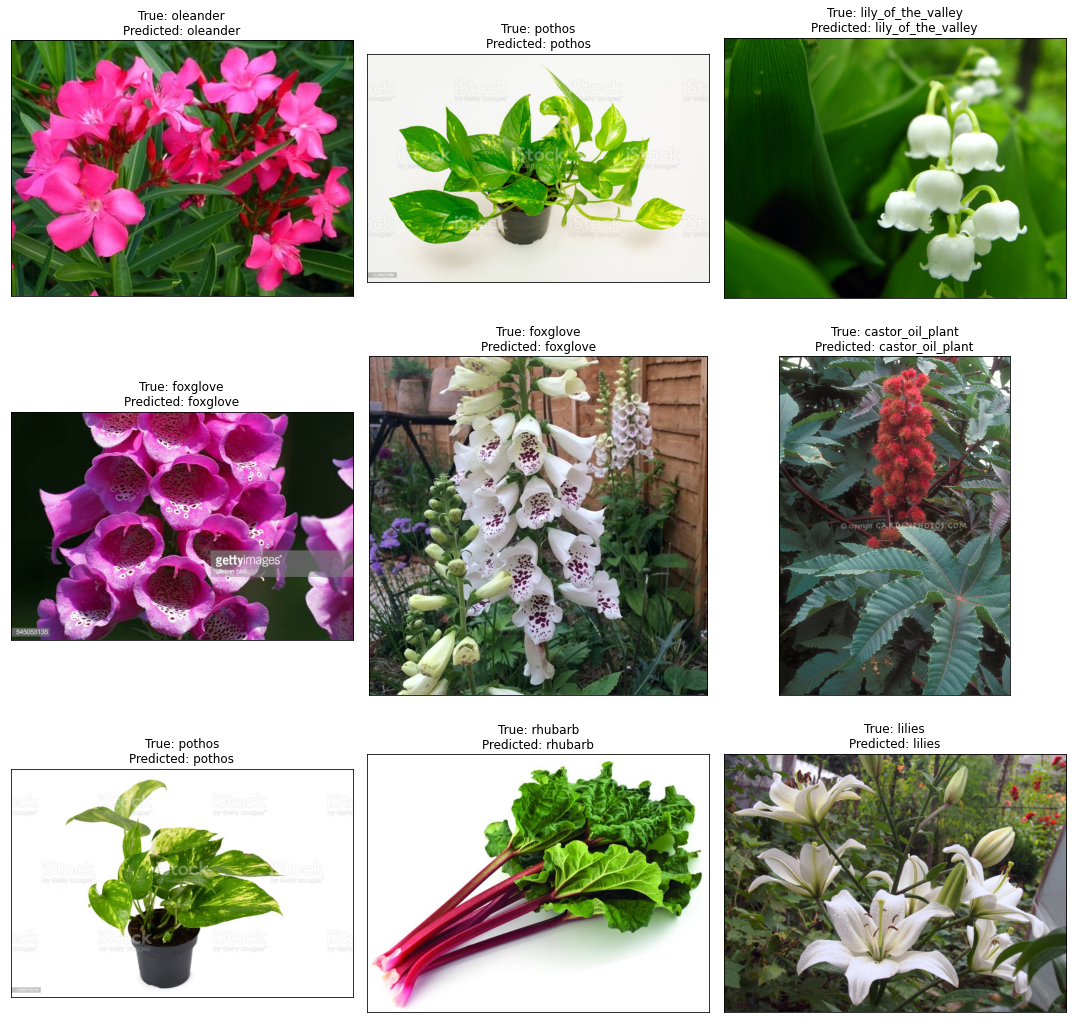

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [ ]:
model.save('/content/model/12_15_22.h5')